# Introduction to the ice fitting workshop - 10/jun/2022

### Continuum determination (Blackbody approach)

Continuum is the "baseline" in the spectral energy distribution of a protostar, i.e., the profile that lies just above absorption bands or just below emission features. Two methods are introduced here in this part of the tutorial:

1) Polynomial function - A low order polynomial is used to trace the continuum curve within a specific range.

2) Blackbody combination - One or more blackbody functions are linearly combined to fit/extract the protostellar continuum spectrum.

*These two methods have advantages and disadvantages, which will be dicussed in the live demonstration.*


### Blackbody combination

A blackbody function given below is used to determine the continuum SED in the protostellar spectrum.

$F_{\rm{BB}} (\lambda, T) = \sum_{i=1}^{m} f_i \frac{2hc^2}{\lambda^5} \left(exp\left[\frac{hc}{\lambda k_B T_i} \right] - 1 \right)^{-1}$,

where $f_i$ is a scaling factor, $h$ is the Planck's constant, $c$ is the light velocity, $k_B$ is the Boltzmann's constant and $T_i$ is the blackbody temperature for the blackbody curve $i$.

To determine the continuum SED with this method using ENIIGMA, you can use the funtion **Fit.Continuum_BB**. The input information used by this function are:

1) filename: the path to the file containing the protostar spectrum in Jy units;

2) the full range where the continuum SED will be caculated;

3) range limits: the specific ranges to fit the protostar spectrum. Useful to skip regions with absorption or emission profiles;

4) guess: the initial guess for the fitting;

5) guess_view: overplots the initial guess in the final plot.

An example of the **Fit.Continuum_BB** is given below. The filename reads the file *svs49.txt*. This file combines VLT/ISAAC L band spectrum with 2MASS photometric data.

### Optical depth determination

When the continuum SED is calculated, the protostar spectrum is converted to an optical depth scale, given by:

$\tau_{\lambda} = -\rm{ln}\left(\frac{F_{\lambda}^{obs}}{F_{\lambda}^{cont}} \right)$
where $F_{\lambda}^{obs}$ is the observed flux and $F_{\lambda}^{cont}$ is the continuum SED.

The outputfile has an *.od* extension (e.g., svs49.od). This file can be used in the next step for optmization.

**None: A poor continuum determination leads to inacuracies in the optical depth spectrum!**

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import glob
from scipy.interpolate import interp1d
import scipy.optimize as optimize
import os
%matplotlib notebook

In [15]:
#======= nature constants (seem global) =====================
cl      = 2.99792458E+08  # speed of light [m/s]
h = 6.62607554E-34  # Planck's constant [J s]
bk      = 1.38065812E-23  # Boltzmann's constant [J/K]
pi      = np.pi           # just pi
dir = os.getcwd()


In [16]:
def find_nearest(array, value):
    """
    Find nearest value of a given number.

    Parameters
    -------------

    array : 'numpy.ndarray'
        Vector with the value of interest.

    value : 'float'
        Value of interest.

    Returns
    -------------
    Nearest value

    """

    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

def get_line_number2(value, matrix):
    """
    Function used to get the line number of a value in a array.

    Parameters
    -------------

    value : 'float'
        Value of interest.

    matrix : 'numpy.ndarray'
        Vector with the value of interest.

    Returns
    ------------

    Index

    """

    for i, line in enumerate(matrix, 1):
        if line == value:
            return i

In [17]:
def BB_func(lam, pars):
    """
    Blackbody function used for spectral decomposition.

    Parameters
    -------------

    lam : 'numpy.ndarray'
        The x axis used in the sepctral decomposition. E.g. the wavelenght.

    pars : 'numpy.ndarray'
        Two parameters used in the blackbody function. They are the temperature T and the scaling factor C. E.g. [T, C].

    Returns
    -------------
    Blackbody funciton.

    """
    T = pars[0]
    C = pars[1]
    lam = 1e-6 * lam # convert to metres
    B_lam = C*4*pi*2*h*c**2 / (lam**5 * (np.exp(h*c / (lam*k*T)) - 1))
    F = B_lam*lam*1e-4
    #f = a0*np.exp(-(t - a1)**2/(2*a2**2))
    return  F#returns units of W/cm2

def one_BB(lam, *pars):    
    """
    One blackbody function used for spectral decomposition.

    Parameters
    -------------

    lam : 'numpy.ndarray'
        The x axis used in the sepctral decomposition. E.g. the wavelenght.

    pars : 'numpy.ndarray'
        Two parameters used in the blackbody function. They are the temperature T and the scaling factor C. E.g. [T, C].

    Returns
    -------------
    One blackbody component.

    """

    T1 = pars[0]  
    C1 = pars[1]   
    p1 = BB_func(lam, [T1, C1])
    return p1

def two_BB(lam, *pars):    
    """
    Composition of two blackbody functions used for spectral decomposition.

    Parameters
    -------------

    lam : 'numpy.ndarray'
        The x axis used in the sepctral decomposition. E.g. the wavelenght.

    pars : 'numpy.ndarray'
        Two parameters used in the blackbody function. They are the temperature T and the scaling factor C. E.g. [T, C].

    Returns
    -------------
    Sum of two blackbody functions

    """

    T1 = pars[0]  
    C1 = pars[1]   
    T2 = pars[2]  
    C2 = pars[3]  
    p1 = BB_func(lam, [T1, C1])
    p2 = BB_func(lam, [T2, C2])
    return p1 + p2

def three_BB(lam, *pars):    
    """
    Composition of three blackbody functions used for spectral decomposition.

    Parameters
    -------------

    lam : 'numpy.ndarray'
        The x axis used in the sepctral decomposition. E.g. the wavelenght.

    pars : 'numpy.ndarray'
        Two parameters used in the blackbody function. They are the temperature T and the scaling factor C. E.g. [T, C].

    Returns
    -------------
    Sum of three blackbody functions

    """

    T1 = pars[0]  
    C1 = pars[1]   
    T2 = pars[2]  
    C2 = pars[3]
    T3 = pars[4]  
    C3 = pars[5]  
    p1 = BB_func(lam, [T1, C1])
    p2 = BB_func(lam, [T2, C2])
    p3 = BB_func(lam, [T3, C3])
    return p1 + p2 + p3

def Continuum_BB(filename, xmin, xmax, range_limits=None, guess = (500, 1e-18, 200, 3e-16), guess_view = False):
    """
    Calculates the continuum of the Spectral Energy Distribution (SED) using the polynomial fitting.

    Parameters
    -------------

    filename : 'str'
        Three columns file containing the wavelength in units of micrometers, the flux in units of Jansky and the flux error.

    xmin, xmax : 'float'
        Intervals used to calculate the continuum in units of micrometers.

    order : 'float'
        Polynomial order.

    range_limits : 'numpy.ndarray'
        Ranges adopted for the continuum in units of micrometers. E.g. [[2.,3.], [8.,9]]. The funtion will take only these intervals to perform the fit.
        The rest of the spectrum will be masked.
        Default: None

    guess: 'numpy.ndarray'
        Initial guesses for the blackbody continuum calculation.

    guess_view: 'bool'
        Show the initial guess on the plot.
        Default: False


    Returns
    -------------
    ASCII files

    Flux_filename.flux (units of W cm-2)

    BB_Cont_filename.cont (units of W cm-2)

    Optical_depth_filename.od

    Continuum_filename.pdf

    """


    #======================================================================
    print('Determining the continuum...')
    #=================Input Parameters ====================================

    #=================Input Parameters ====================================

    files = glob.glob(filename)

    count = 0
    fig = plt.figure()
    i = len(files)

    for index in range(i):
        name = files[index].rsplit('/', 1)[1]
        t = np.loadtxt(files[index]).T
        x_lam = t[0]
        x_nu = cl/(x_lam*1e-6)
        y = t[1]
        ey = t[2]
        y2 = x_nu*y*1e-30
        ey2 = x_nu*ey*1e-30
        ratio = ey2/y2

        range_limits = range_limits

        if range_limits != None:
            xrange1t = []
            yrange1t = []
            eyrange1t = []
            for i in range(len(range_limits)):
                id_n = []
                for j in range(2):
                    frg_lam1 = range_limits[i][j]
                    rg1 = find_nearest(x_lam, frg_lam1) #find number nearby
                    id_n.append(get_line_number2(rg1, x_lam))
                xrange1t.append(x_lam[id_n[0]:id_n[1]])
                yrange1t.append(y2[id_n[0]:id_n[1]])
                eyrange1t.append(ey2[id_n[0]:id_n[1]])

            xrange1t2 = []
            yrange1t2 = []
            eyrange1t2 = []
            for i in range(len(xrange1t)):
                for j in range(len(xrange1t[i])):
                    xrange1t2.append(xrange1t[i][j])
                    yrange1t2.append(yrange1t[i][j])
                    eyrange1t2.append(eyrange1t[i][j])
        else:
            print('here1')
            xrange1t2, yrange1t2, eyrange1t2 = x_lam, y2, ey2


        np.savetxt('Flux_'+name.split('.')[0]+'.flux', np.transpose([x_lam, y2])) #Save the flux in W cm-2 s-1

        lam1, lam2 = xmin, xmax
        pp1 = find_nearest(x_lam, lam1)
        pp2 = find_nearest(x_lam, lam2)
        npoints = 1000
        tt = np.linspace(pp1, pp2, npoints)

        guess = guess

        sub1=fig.add_subplot(211)
        if len(guess) == 2:
            popt, pcov = optimize.curve_fit(one_BB, xrange1t2, yrange1t2, guess, sigma=eyrange1t2, maxfev=5000) #sigma=z_i_new, #BB fitting
            FcontBB= one_BB(tt, *popt)
            np.savetxt('BB_Cont_'+name.split('.')[0]+'.cont', np.transpose([tt, FcontBB]))
            pars1 = popt[0:2]
            peak1 = BB_func(tt, pars1)
            sub1.plot(tt, -1*np.log10(peak1), ':', label=r'C$_{BB{_1}}$'+'(T = '+ str(round(popt[0],1)) + 'K)')

            if guess_view == True:
                y11 = BB_func(tt, [guess[0], guess[1]])
                ytot = y11
                sub1.plot(tt, -1*np.log10(ytot), '-', lw=2, label='total guess', color='limegreen')
                sub1.plot(tt, -1*np.log10(y11), ':', lw=2, label='guess 1')# % popt[0])

        elif len(guess) == 4:
            popt, pcov = optimize.curve_fit(two_BB, xrange1t2, yrange1t2, guess, sigma=eyrange1t2, maxfev=5000) #sigma=z_i_new, #BB fitting
            FcontBB= two_BB(tt, *popt)
            np.savetxt('BB_Cont_'+name.split('.')[0]+'.cont', np.transpose([tt, FcontBB]))
            pars1 = popt[0:2]
            pars2 = popt[2:4]
            peak1 = BB_func(tt, pars1)
            peak2 = BB_func(tt, pars2)
            sub1.plot(tt, -1*np.log10(peak1), ':', label=r'C$_{BB{_1}}$'+'(T = '+ str(round(popt[0],1)) + 'K)')
            sub1.plot(tt, -1*np.log10(peak2), ':', label=r'C$_{BB{_2}}$'+'(T = '+ str(round(popt[2],1)) + 'K)')

            if guess_view == True:
                y11 = BB_func(tt, [guess[0], guess[1]])
                y22 = BB_func(tt, [guess[2], guess[3]])
                ytot = y11 + y22
                sub1.plot(tt, -1*np.log10(ytot), '-', lw=2, label='total guess', color='limegreen')
                sub1.plot(tt, -1*np.log10(y11), ':', lw=2, label='guess 1')
                sub1.plot(tt, -1*np.log10(y22), ':', lw=2, label='guess 2')

        elif len(guess) == 6:
            popt, pcov = optimize.curve_fit(three_BB, xrange1t2, yrange1t2, guess, sigma=eyrange1t2, maxfev=5000) #sigma=z_i_new, #BB fitting
            FcontBB= two_BB(tt, *popt)
            np.savetxt('BB_Cont_'+name.split('.')[0]+'.cont', np.transpose([tt, FcontBB]))
            pars1 = popt[0:2]
            pars2 = popt[2:4]
            pars3 = popt[4:6]
            peak1 = BB_func(tt, pars1)
            peak2 = BB_func(tt, pars2)
            peak3 = BB_func(tt, pars3)
            sub1.plot(tt, -1*np.log10(peak1), ':', label=r'C$_{BB{_1}}$'+'(T = '+ str(round(popt[0],1)) + 'K)')
            sub1.plot(tt, -1*np.log10(peak2), ':', label=r'C$_{BB{_2}}$'+'(T = '+ str(round(popt[2],1)) + 'K)')
            sub1.plot(tt, -1*np.log10(peak3), ':', label=r'C$_{BB{_3}}$'+'(T = '+ str(round(popt[4],1)) + 'K)')

            if guess_view == True:
                y11 = BB_func(tt, [guess[0], guess[1]])
                y22 = BB_func(tt, [guess[2], guess[3]])
                y33 = BB_func(tt, [guess[4], guess[5]])
                ytot = y11 + y22 + y33
                sub1.plot(tt, -1*np.log10(ytot), '-', lw=2, label='total guess', color='limegreen')
                sub1.plot(tt, -1*np.log10(y11), ':', lw=2, label='guess 1')# % popt[0])
                sub1.plot(tt, -1*np.log10(y22), ':', lw=2, label='guess 2')# % popt[2])
                sub1.plot(tt, -1*np.log10(y33), ':', lw=2, label='guess 3')# % popt[2])

        try:
            Fdata = interp1d(x_lam,y2, kind='cubic')	#interpolate data
            etau0 = interp1d(x_lam,ratio, kind='cubic')

        except ValueError:
            Fdata = interp1d(x_lam,y2, kind='linear')	#interpolate data
            etau0 = interp1d(x_lam,ratio, kind='linear')

        tau_bb = -1*np.log(Fdata(tt)/FcontBB)
        etau = etau0(tt)
        np.savetxt('Optical_depth_'+name.split('.')[0]+'.od', np.transpose([tt,tau_bb,etau]))

        x_filt_b = x_lam[x_lam <= 2.5]
        y_filt_b = y2[x_lam <= 2.5]
        ey_filt_b = ratio[x_lam <= 2.5]

        x_filt_a = x_lam[x_lam > 2.5]
        y_filt_a = y2[x_lam > 2.5]

        sub1.plot(x_filt_a, -1*np.log10(y_filt_a), color='black', label='Observed data')
        sub1.errorbar(x_filt_b, -1*np.log10(y_filt_b), yerr=0.434*ey_filt_b, marker='s', color='grey', linestyle='None')
        sub1.plot(tt, -1*np.log10(FcontBB), '--', color='r', label='Continuum (Blackbody)')

        sub1.minorticks_on()
        sub1.tick_params(which='major', direction='in', labelsize=10)
        sub1.tick_params(which='minor', direction='in', labelsize=10)

        ymin = min(-1*np.log10(y2)) - 0.005*min(-1*np.log10(y2))
        ymax = max(-1*np.log10(y2)) + 0.05*max(-1*np.log10(y2))

        try:
            plt.ylim(ymax, ymin)
        except ValueError:
            plt.ylim(18, 16)
        plt.xlim(x_lam[0],x_lam[len(x_lam)-1])
        plt.legend(loc='best', frameon=False, fontsize=9)
        plt.ylabel(r'$\mathrm{-log(Flux[W cm^{-2}])}$',fontsize=10)
        plt.xlabel(r'$\lambda\ \mathrm{[\mu m]}$',fontsize=10)

        taumax = max(tau_bb) + 0.1*max(tau_bb)
        ground = tau_bb*0

        sub2=fig.add_subplot(212)
        sub2.plot(tt, tau_bb, label=None)
        sub2.plot(tt, ground, ':')
        sub2.minorticks_on()
        sub2.tick_params(which='major', direction='in', labelsize=10)
        sub2.tick_params(which='minor', direction='in', labelsize=10)
        plt.xlim(x_lam[0],x_lam[len(x_lam)-1])
        plt.ylim(taumax,-0.2)
        plt.tight_layout()
        plt.legend(loc='best', frameon=False, fontsize=9)
        plt.ylabel(r'Optical Depth$\mathrm{(\tau_{\lambda})}$',fontsize=10)
        plt.xlabel(r'$\lambda\ \mathrm{[\mu m]}$',fontsize=10)

        count = count+1

    plt.savefig('Continuum_'+name.split('.')[0]+'.pdf',format='pdf', bbox_inches='tight', dpi=300)

Determining the continuum...


<IPython.core.display.Javascript object>


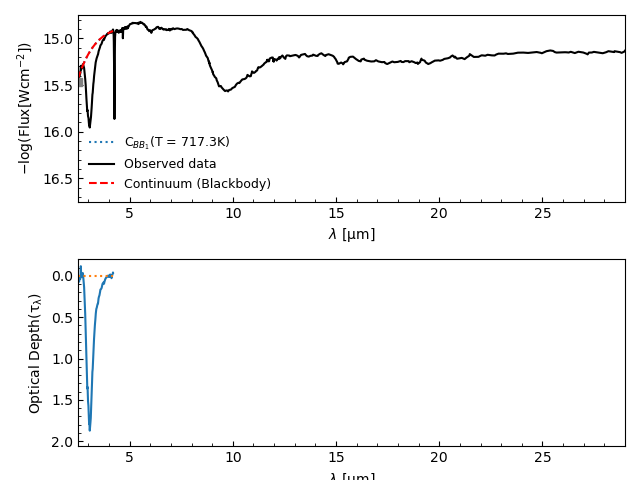

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In [30]:
filename = dir+'/'+'Elias29flux.dat'
Continuum_BB(filename, 2.5, 4.2, range_limits=[[2.5, 2.7], [4.0, 4.1]], guess = (600, 1e-16), guess_view = False)